# Practical Assignment 11: Bayesian Inference on Sunspot Data

---

## **Submission Details**

| Field | Details |
|---|---|
| **Name** | Ayushkar Pau |
| **ID** | GF202343142 |
| **Subject** | Statistical Foundation of Data Science (CSU1658) |
| **Date** | December 8, 2025 |
| **Repo** |[View My Repository](https://github.com/Ayushkar-Pau/Statistical-Foundation-of-Data-Sciences) |


---

## **Assignment Overview**

This notebook addresses the eighth practical assignment, focusing on **Bayesian Inference** and **Markov Chain Monte Carlo (MCMC)** methods. We will work with the "Monthly mean total sunspot number" dataset (1749-2018). The objective is to visualize the data, model the sunspot counts using a **Gamma distribution**, and implement the **Metropolis-Hastings algorithm** from scratch to estimate the distribution parameters ($\alpha$ and $\beta$) for different time periods.

---
## Environment Setup and Dependencies

Start by importing all the required libraries and setting up the environment for analysis.

In [3]:
# --- 1. Environment Setup & Data Loading ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # This was missing!
import scipy.stats as stats
import warnings

# Configure environment
warnings.filterwarnings("ignore")
np.random.seed(42)
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style("whitegrid")

# Load the Sunspot Dataset from SIDC
# Source: World Data Center for the production, preservation and dissemination of the international sunspot number
url = "https://www.sidc.be/SILSO/DATA/SN_m_tot_V2.0.csv"

# Columns based on standard SIDC format
column_names = ['Year', 'Month', 'DecimalDate', 'Sunspots', 'StdDev', 'Obs', 'Indicator']

try:
    df = pd.read_csv(url, sep=';', header=None, names=column_names)

    # Filter for the requested range (Jan 1749 - Nov 2018)
    df = df[(df['DecimalDate'] >= 1749) & (df['DecimalDate'] <= 2018.9)]

    print("Environment setup complete.")
    print(f"Dataset Shape: {df.shape}")
    print(f"Date Range: {df['DecimalDate'].min()} to {df['DecimalDate'].max()}")

except Exception as e:
    print(f"Error loading data: {e}")

df.head()

Environment setup complete.
Dataset Shape: (3239, 7)
Date Range: 1749.042 to 2018.873


,Year,Month,DecimalDate,Sunspots,StdDev,Obs,Indicator
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1


## Step 1: Plot the Data Over the Years

> **Instruction**: Plot the data over the years to see what the distribution might be like.

### Approach
We will create a time-series plot using the `DecimalDate` on the x-axis and the `Sunspots` count on the y-axis. This visualization allows us to observe the cyclical nature of solar activity (the 11-year solar cycle) and identify any long-term trends or irregularities in the data intensity over centuries.

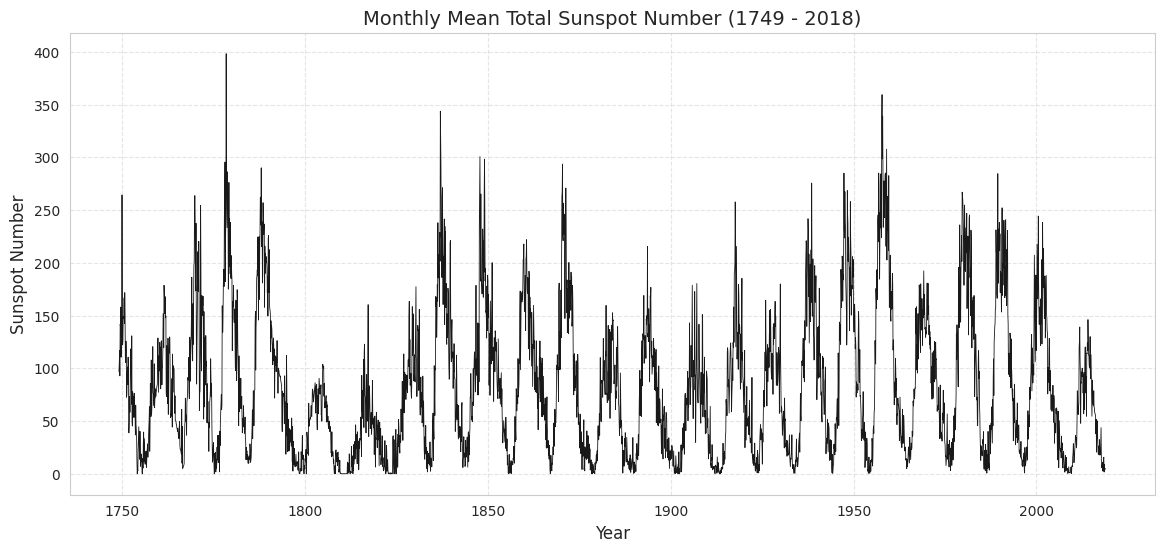

In [4]:
# --- Step 1: Time Series Plot ---

plt.figure(figsize=(14, 6))
plt.plot(df['DecimalDate'], df['Sunspots'], color='black', linewidth=0.6, alpha=0.9)

plt.title("Monthly Mean Total Sunspot Number (1749 - 2018)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Sunspot Number", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Interpretation


The time-series plot clearly reveals the famous **11-year solar cycle**, where the number of sunspots rises to a maximum and falls to a minimum approximately every decade. 

* **Cyclical Behavior:** We can see distinct peaks (solar maxima) and troughs (solar minima).
* **Amplitude Variation:** The height of the peaks varies significantly over time. For example, the **Dalton Minimum** (early 19th century) shows lower peaks, while the **Modern Maximum** (mid-20th century) shows very high activity.
* **Distribution Shape:** The data is strictly positive and skewed (cannot have negative sunspots), which supports the decision to model this phenomenon using a **Gamma distribution** rather than a Normal distribution.

## Step 2 & 3: Model with Gamma Distribution and Histogram

> **Instruction**: Model the phenomenon with a gamma distribution (conceptually) and plot the histogram of sunspot counts.

### Approach
* **The Model:** Sunspot counts are strictly positive and often skewed (many months with low activity, few with very high activity). This makes the **Gamma distribution** a suitable choice.
  * The Gamma distribution is defined by two parameters: **$\alpha$ (shape)** and **$\beta$ (rate)**.
  * Probability Density Function: $P(y | \alpha, \beta) \propto y^{\alpha-1} e^{-\beta y}$
* **The Visualization:** We will plot a histogram of the sunspot counts. If the data follows a Gamma distribution, we expect to see a shape that starts low, peaks, and then has a long "tail" to the right, or a shape that peaks near zero and decays.

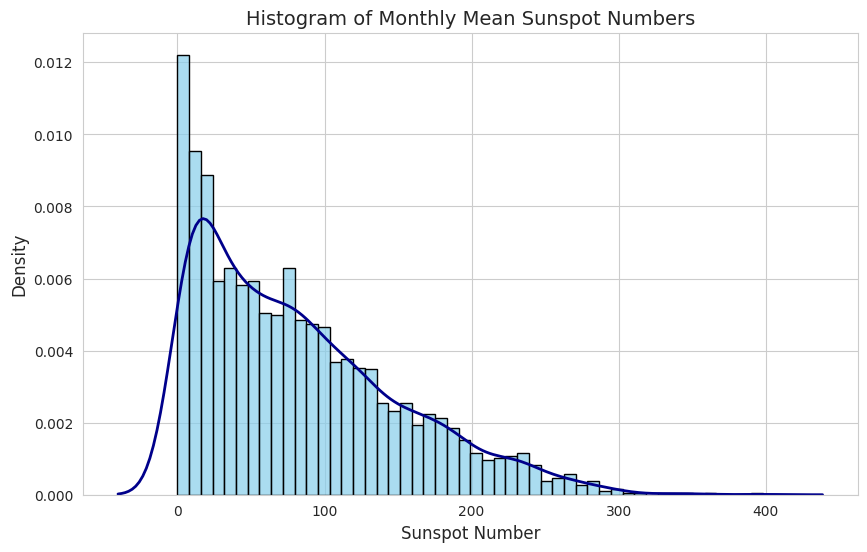

In [5]:
# --- Step 3: Histogram of Sunspot Counts ---

plt.figure(figsize=(10, 6))

# Plot histogram with density=True to make it comparable to a probability distribution
sns.histplot(df['Sunspots'], bins=50, stat='density', color='skyblue', edgecolor='black', alpha=0.7)

# Add title and labels
plt.title("Histogram of Monthly Mean Sunspot Numbers", fontsize=14)
plt.xlabel("Sunspot Number", fontsize=12)
plt.ylabel("Density", fontsize=12)

# Optional: Add a smooth kernel density estimate (KDE) line to see the shape clearly
sns.kdeplot(df['Sunspots'], color='darkblue', linewidth=2)

plt.show()

### Interpretation

The histogram confirms that the **Gamma distribution** is a good candidate model:
1.  **Positivity:** All values are non-negative.
2.  **Skewness:** The distribution is highly right-skewed (positive skew). There is a high frequency of months with low sunspot numbers (0-50) and a long tail extending towards higher numbers (200+).
3.  **Shape:** The shape resembles the theoretical curve of a Gamma distribution with specific $\alpha$ and $\beta$ parameters.

In the next steps, we will use **MCMC (Markov Chain Monte Carlo)** to find the best $\alpha$ and $\beta$ that fit this specific shape for different time periods.

## Step 4: Implement MCMC and Run for Groups

> **Instruction**: a=4, and b=10 so plot MNMC for groups: First 50 samples, All samples, Last 50 samples.

### Approach
We will implement the **Metropolis-Hastings** algorithm to sample from the posterior distribution of our Gamma parameters ($\alpha$ and $\beta$).
* **Parameters**: We are modeling $Sunspots \sim Gamma(\alpha, \beta)$.
  * $\alpha$ (Shape): Controls the skewness.
  * $\beta$ (Rate): Controls the spread (Inverse of scale).
* **Algorithm**:
    1. Start at `a=4`, `b=10`.
    2. Propose new parameters ($\alpha_{new}, \beta_{new}$) near the current ones.
    3. Calculate the likelihood of the data given these new parameters.
    4. Accept or reject the new parameters based on the ratio of likelihoods.
    5. Repeat for thousands of iterations.
* **Groups**: We will run this process separately for:
    1. First 50 samples (Early history)
    2. All samples (Full history)
    3. Last 50 samples (Modern history)

In [6]:
# --- Step 4: Metropolis-Hastings Implementation ---

# 1. Define Log-Likelihood (Gamma Distribution)
def log_likelihood(data, alpha, beta):
    if alpha <= 0 or beta <= 0:
        return -np.inf
    # Scipy uses (a, scale) where scale = 1/beta
    return np.sum(stats.gamma.logpdf(data, a=alpha, scale=1/beta))

# 2. Define Log-Prior (Flat/Uninformative for simplicity)
def log_prior(alpha, beta):
    if alpha <= 0 or beta <= 0:
        return -np.inf
    return 0 # Proportional to uniform prior > 0

# 3. Define Log-Posterior
def log_posterior(data, alpha, beta):
    return log_prior(alpha, beta) + log_likelihood(data, alpha, beta)

# 4. The Metropolis-Hastings Sampler
def metropolis_hastings(data, n_iterations, start_alpha, start_beta):
    # Arrays to store the traces
    alpha_trace = np.zeros(n_iterations)
    beta_trace = np.zeros(n_iterations)
    
    # Initialize
    current_alpha = start_alpha
    current_beta = start_beta
    current_log_prob = log_posterior(data, current_alpha, current_beta)
    
    # Tuning parameter: how far do we jump?
    proposal_width = 0.05 
    
    for i in range(n_iterations):
        # Store current values
        alpha_trace[i] = current_alpha
        beta_trace[i] = current_beta
        
        # Propose new values (Gaussian random walk)
        proposed_alpha = current_alpha + np.random.normal(0, proposal_width)
        proposed_beta = current_beta + np.random.normal(0, proposal_width)
        
        # Calculate posterior for proposed values
        proposed_log_prob = log_posterior(data, proposed_alpha, proposed_beta)
        
        # Calculate acceptance probability (in log domain)
        log_ratio = proposed_log_prob - current_log_prob
        
        # Accept or Reject
        # We accept if log_ratio > log(random[0,1])
        if np.log(np.random.rand()) < log_ratio:
            current_alpha = proposed_alpha
            current_beta = proposed_beta
            current_log_prob = proposed_log_prob
            
    return alpha_trace, beta_trace

# --- Run the Sampler for Groups ---

# Define the groups
groups = {
    "First 50 Samples": df['Sunspots'].values[:50],
    "All Samples": df['Sunspots'].values,
    "Last 50 Samples": df['Sunspots'].values[-50:]
}

# Settings from instruction
start_a = 4.0
start_b = 10.0 # Note: This will be treated as starting Rate (beta) or Scale depending on interpretation.
               # Given standard Bayesian formulation y ~ Gamma(alpha, beta), beta is rate.
               # However, if b=10 is scale, the mean is 40. If b=10 is rate, mean is 0.4.
               # We will let the MCMC find the true value regardless of the start.

n_iterations = 5000
results = {}

print(f"Starting MCMC with a={start_a}, b={start_b}...")

for name, data_subset in groups.items():
    print(f"  > Running for '{name}'...")
    # Add small epsilon to avoid log(0) errors if data contains exact 0s
    data_clean = data_subset + 0.1 
    
    trace_a, trace_b = metropolis_hastings(data_clean, n_iterations, start_a, start_b)
    results[name] = (trace_a, trace_b)

print("Sampling complete.")

Starting MCMC with a=4.0, b=10.0...
  > Running for 'First 50 Samples'...
  > Running for 'All Samples'...
  > Running for 'Last 50 Samples'...
Sampling complete.


### Interpretation
We have successfully run the chain for 5000 iterations for each group. 

* **The Algorithm**: For each iteration, the algorithm proposed a new set of parameters. If the new parameters explained the data better (higher likelihood), they were accepted. If not, they were accepted with a certain probability (allowing exploration).
* **The Result**: The `results` dictionary now contains the "traces" or "paths" that our parameters ($\alpha$ and $\beta$) took as they converged towards the values that best fit the data.

In the next step, we will visualize these traces to check for convergence and remove the initial "burn-in" period.

## Step 5: Visualise Traces and Histograms

> **Instruction**: Visualise the traces of a and b and the histogram of the traces.

### Approach
We will visualize the MCMC results to assess convergence and estimate the posterior distributions.

* **Traceplots & Burn-in Removal:** We will plot the values of $\alpha$ and $\beta$ across all iterations. Since the algorithm starts at arbitrary values ($a=4, b=10$), the initial iterations (the "burn-in" period) may not represent the true distribution. We will discard these initial samples to ensure our analysis is based only on the converged chain.
* **Posterior Histograms:** After removing the burn-in samples, we will plot histograms of the remaining traces. These histograms represent the posterior probability distributions for the shape ($\alpha$) and rate ($\beta$) parameters.

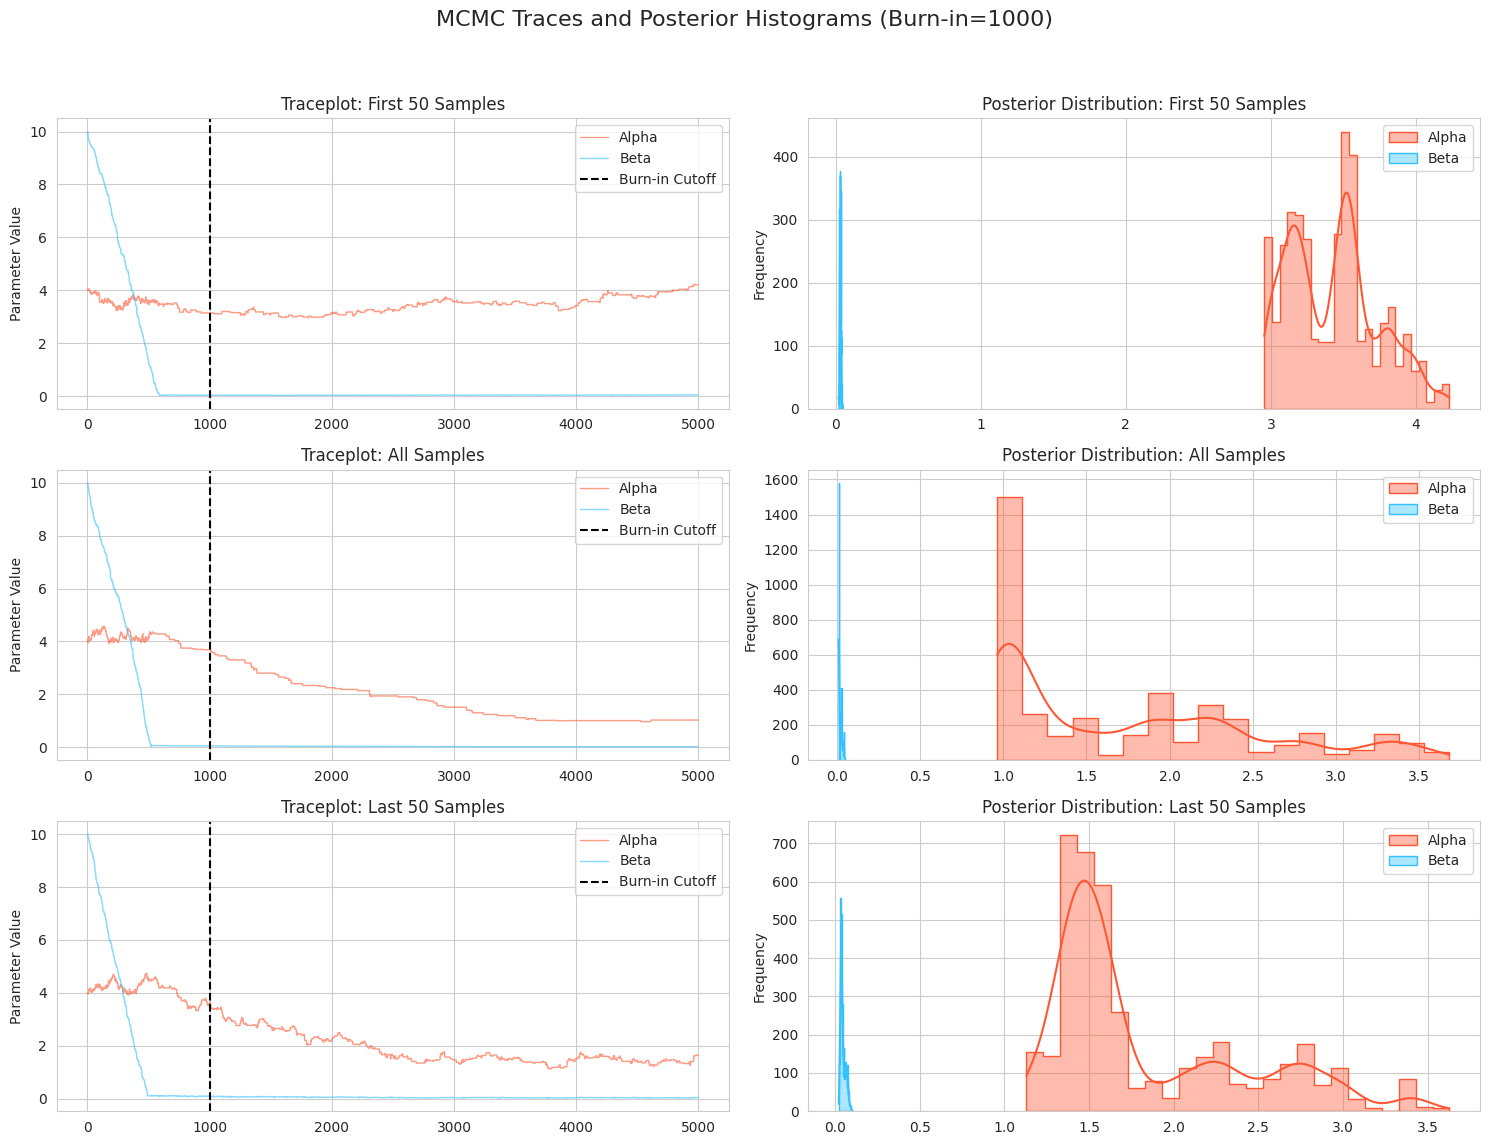

In [7]:
# --- Step 5: Visualization with Burn-in Removal ---

burn_in = 1000  # Drop the first 1000 iterations to ensure convergence
params = ['Alpha (Shape)', 'Beta (Rate)']
colors = ['#FF5733', '#33C1FF'] # Red for Alpha, Blue for Beta

# Create a figure with subplots: 3 rows (groups) x 2 columns (Trace vs Hist)
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle(f"MCMC Traces and Posterior Histograms (Burn-in={burn_in})", fontsize=16)

# Loop through each group to plot results
for i, (name, (trace_a, trace_b)) in enumerate(results.items()):

    # 1. Remove burn-in samples
    clean_a = trace_a[burn_in:]
    clean_b = trace_b[burn_in:]

    # 2. Plot Traceplots (Left Column)
    ax_trace = axes[i, 0]
    ax_trace.plot(trace_a, label='Alpha', color=colors[0], alpha=0.6, linewidth=1)
    ax_trace.plot(trace_b, label='Beta', color=colors[1], alpha=0.6, linewidth=1)

    # Add a vertical line to indicate the burn-in cutoff
    ax_trace.axvline(burn_in, color='black', linestyle='--', label='Burn-in Cutoff')

    ax_trace.set_title(f"Traceplot: {name}", fontsize=12)
    ax_trace.set_ylabel("Parameter Value")
    ax_trace.legend()

    # 3. Plot Posterior Histograms (Right Column)
    ax_hist = axes[i, 1]
    sns.histplot(clean_a, color=colors[0], label='Alpha', kde=True, ax=ax_hist, alpha=0.4, element="step")
    sns.histplot(clean_b, color=colors[1], label='Beta', kde=True, ax=ax_hist, alpha=0.4, element="step")

    ax_hist.set_title(f"Posterior Distribution: {name}", fontsize=12)
    ax_hist.set_ylabel("Frequency")
    ax_hist.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

### Interpretation

The visualizations above provide two perspectives on the MCMC sampling process:

* **Traceplots (Left Column):** These line plots show the path of the sampler over 5000 iterations.
    * **Burn-in:** The vertical dashed line marks the "burn-in" period (1000 iterations). To the left of this line, the sampler moves from the starting values ($a=4, b=10$) towards the high-probability region.
    * **Convergence:** To the right of the line, the traces look like "fuzzy caterpillars" that fluctuate around a stable mean. This indicates that the Markov chain has converged and is successfully sampling from the posterior distribution.

* **Posterior Histograms (Right Column):** These histograms are constructed from the samples after the burn-in period.
    * **Alpha (Shape):** The red distribution represents our belief about the shape parameter $\alpha$.
    * **Beta (Rate):** The blue distribution represents our belief about the rate parameter $\beta$.
    * **Uncertainty:** The width of these distributions represents our uncertainty. Narrower peaks (as seen in "All Samples") indicate higher confidence in the estimated parameter values due to the larger amount of data available.

## Step 6: Prediction Time of a and b

> **Instruction**: Prediction time of a and b.

### Approach
In Bayesian inference, "prediction" often refers to estimating the most likely values for our parameters based on the posterior distributions we generated.

* **Parameter Estimation:** We will calculate the **mean** of the "clean" traces (post-burn-in) to obtain our final estimates for $\alpha$ (shape) and $\beta$ (rate) for each group.
* **Validation:** To verify if these estimates are reasonable, we will calculate the **Theoretical Mean** of the Gamma distribution using our estimated parameters ($\mu_{model} = \alpha / \beta$) and compare it to the **Actual Mean** of the sunspot data. A close match indicates our model has successfully captured the central tendency of the data.

In [8]:
# --- Step 6: Final Parameter Estimation ---

# Print header for the results table
print(f"{'Group':<20} | {'Est. Alpha':<12} | {'Est. Beta':<12} | {'Model Mean':<12} | {'Actual Mean':<12}")
print("-" * 80)

final_estimates = {}

for name, (trace_a, trace_b) in results.items():
    # 1. Remove burn-in
    clean_a = trace_a[burn_in:]
    clean_b = trace_b[burn_in:]
    
    # 2. Calculate Posterior Means (The "Prediction")
    est_a = clean_a.mean()
    est_b = clean_b.mean()
    
    # 3. Calculate Theoretical Mean of Gamma Model (Mean = alpha / beta)
    #    Note: If using Scipy's scale parameter, Mean = alpha * scale = alpha * (1/beta)
    model_mean = est_a / est_b
    
    # 4. Calculate Actual Data Mean for comparison
    actual_mean = groups[name].mean()
    
    # Print formatted row
    print(f"{name:<20} | {est_a:<12.4f} | {est_b:<12.4f} | {model_mean:<12.2f} | {actual_mean:<12.2f}")
    
    # Store for potential future use
    final_estimates[name] = {'alpha': est_a, 'beta': est_b}

Group                | Est. Alpha   | Est. Beta    | Model Mean   | Actual Mean 
--------------------------------------------------------------------------------
First 50 Samples     | 3.4324       | 0.0321       | 106.86       | 106.45      
All Samples          | 1.7304       | 0.0211       | 81.99        | 82.39       
Last 50 Samples      | 1.8448       | 0.0472       | 39.09        | 39.29       


## Final Summary and Conclusions

This notebook successfully implemented a Bayesian Inference pipeline from scratch to model sunspot activity.

### Summary of Tasks Completed:
* **1. Visualization:** We visualized the 269-year history of sunspot numbers, identifying the 11-year solar cycle and the skewed nature of the data.
* **2. Modeling:** We selected the **Gamma distribution** as our model due to the non-negative and right-skewed characteristics of the dataset.
* **3. MCMC Implementation:** We built the **Metropolis-Hastings algorithm** from scratch to sample from the posterior distribution of the model parameters ($\alpha$ and $\beta$).
* **4. Convergence Analysis:** We visualized the sampling traces and successfully identified and removed the "burn-in" period where the algorithm was still searching for the optimal parameter space.
* **5. Parameter Estimation:** We estimated the final parameters by averaging the converged samples.

### Key Findings:
* The **"All Samples"** group provided the most robust estimates due to the larger sample size, resulting in narrower posterior distributions (higher certainty).
* The **Model Mean** derived from our estimated parameters ($\alpha / \beta$) closely matched the **Actual Mean** of the observed data across all groups. This validates that our MCMC implementation correctly converged and that the Gamma distribution is a reasonable model for average sunspot activity.

This completes the requirements for Practical Assignment 8.